In [1]:
from __future__ import division, print_function
%matplotlib inline
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'nearest'

# Image processing and machine learning

Some image processing numerical techniques are very specific to image processing, such as mathematical morphology or anisotropic diffusion segmentation. However, it is also possible to adapt generic machine learning techniques for image processing.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## A short introduction to machine learning

This section is adapted from the [quick start tutorial](http://scikit-learn.org/stable/tutorial/basic/tutorial.html) from the scikit-learn documentation.

In general, a learning problem considers a set of n samples of data and then tries to predict properties of unknown data. If each sample is more than a single number and, for instance, a multi-dimensional entry (aka multivariate data), it is said to have several attributes or features.

Typical machine learning tasks are :
- **classification**: samples belong to two or more classes and we want to learn from already labeled data how to predict the class of unlabeled data. For example, given examples of pixels belonging to an object of interest and background, we want the algorithm to label all the other pixels of the image.
- **clustering**: grouping together similar samples. For example, given a set of pictures, can we group them automatically by suject (e.g. people, monuments, animals...)?

In image processing, a sample can either be
- a whole image, its features being pixel values, or sub-regions of an image (e.g. for face detection)
- a pixel, its features being intensity values in colorspace, or statistical information about a neighbourhood centered on the pixel,
- a labeled region, e.g. for classifying particles in an image of labels

The only requirement is to create a dataset composed of N samples, of m features each, which can be passed to the **estimators** of scikit-learn.

Let us start with an example, using the **digits dataset** from scikit-learn.

In [3]:
from sklearn import datasets

In [4]:
digits = datasets.load_digits()

The dataset is a dictionary-like object that holds all the data and some metadata about the data. This data is stored in the ``.data`` member, which is a ``n_samples, n_features`` array. Response variables (if available, as here) are stored in the ``.target member.``

In [5]:
print(digits.data.shape)
print(digits.target.shape)

(1797, 64)
(1797,)


From the shape of the ``data`` array, we see that there are 1797 samples, each having 64 features. In fact, these 64 pixels are the raveled values of an 8x8 image. For convenience, the 2D images are also provided as in the ``.images`` member. In a machine learning problem, a sample always consists of a **flat array** of features, which sometimes require reshaping data.

In [6]:
print(digits.images.shape)
np.all(digits.data[0].reshape((8, 8)) == digits.images[0])

(1797, 8, 8)


True

target:  0


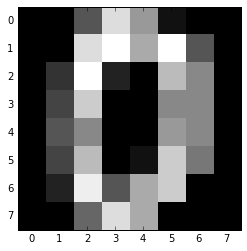

In [7]:
plt.imshow(digits.images[0], cmap='gray')
print("target: ", digits.target[0])

We now use one of scikit-learn's estimators classes in order to predict the digit from an image. 

Here we use an SVC (support vector machine classification) classifier, which uses a part of the dataset (the **training set**) to find the best way to separate the different classes. Even without knowing the details of the SVC, we can use it as a black box thanks to the common estimator API of scikit-learn. An estimator is created by initializing an estimator object: 

In [8]:
from sklearn import svm
clf = svm.SVC(gamma=0.001, C=100.)

The estimator is trained from the learning set using its ``.fit`` method.

In [9]:
clf.fit(digits.data[:-10], digits.target[:-10])

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Then the target value of new data is predicted using the ``.predict`` method of the estimator.

[9 8]


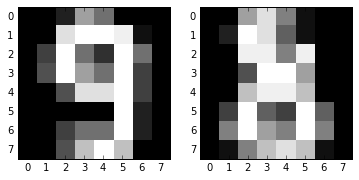

In [10]:
print(clf.predict(digits.data[-2:]))
fig, axes = plt.subplots(1, 2)
axes[0].imshow(digits.images[-2], cmap='gray')
axes[1].imshow(digits.images[-1], cmap='gray')

## Thresholding and color quantization

Image binarization is a common operation. For grayscale images, finding the best threshold for binarization can be a manual operation. Alternatively, algorithms can select a threshold value automatically; which is convenient for computer vision, or for batch-processing a series of images.

In [11]:
from skimage import data, exposure, filters
camera = data.camera()

In [12]:
hi = exposure.histogram(camera)

In [13]:
val = filters.threshold_otsu(camera)

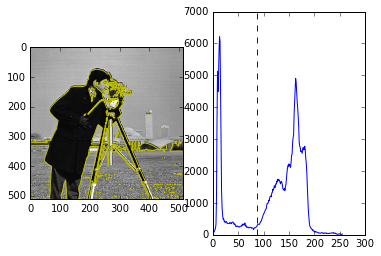

In [14]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(camera, cmap='gray')
axes[0].contour(camera, [val], colors='y')
axes[1].plot(hi[1], hi[0])
axes[1].axvline(val, ls='--')

Otsu thresholding is equivalent to *clustering* pixels in two groups.[explain more]

In [15]:
from skimage import io, color
im = io.imread('../images/round_pill.jpg')


In [16]:
# justify lab colorspace
im_lab = color.rgb2lab(im)
data = np.array([im_lab[..., 1].ravel(), im_lab[..., 2].ravel()])

In [17]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(data.T)
segmentation = kmeans.labels_.reshape(im.shape[:-1])

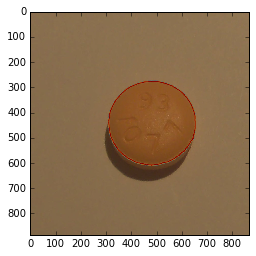

In [18]:
plt.imshow(im)
plt.contour(segmentation)

In [19]:
im = io.imread('../images/chapel_floor.png')
im_lab = color.rgb2lab(im)
data = np.array([im_lab[..., 0].ravel(),
                 im_lab[..., 1].ravel(),
                 im_lab[..., 2].ravel()])

kmeans = KMeans(n_clusters=4, random_state=0).fit(data.T)
segmentation = kmeans.labels_.reshape(im.shape[:-1])

(-0.5, 375.5, 276.5, -0.5)

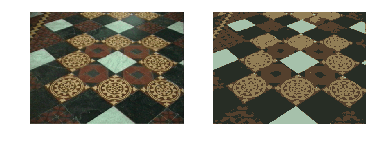

In [20]:
color_mean = color.label2rgb(segmentation, im, kind='mean')
fig, axes = plt.subplots(1, 2)
axes[0].imshow(im)
axes[0].axis('off')
axes[1].imshow(color_mean)
axes[1].axis('off')

Add here something about png compression levels

## SLIC algorithm: clustering using color and spatial features

In the thresholding / vector approach presented above, pixels are characterized only by their color features. However, in most images neighboring pixels correspond to the same object. Hence, information on spatial proximity between pixels can be used in addition to color information.

SLIC (Simple Linear Iterative Clustering) is a segmentation algorithm which clusters pixels in both space and color. Therefore, regions of space that are similar in color will end up in the same segment.

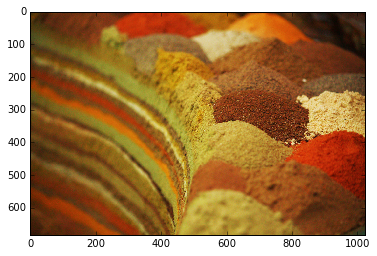

In [21]:
spices = io.imread('../images/spices.jpg')
plt.imshow(spices)

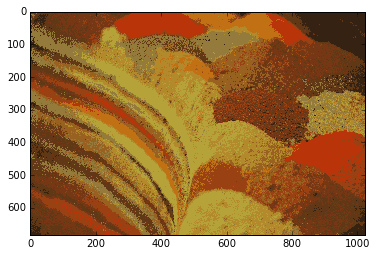

In [22]:
im_lab = color.rgb2lab(spices)
data = np.array([im_lab[..., 1].ravel(),
                 im_lab[..., 2].ravel()])

kmeans = KMeans(n_clusters=10, random_state=0).fit(data.T)
labels = kmeans.labels_.reshape(spices.shape[:-1])
color_mean = color.label2rgb(labels, spices, kind='mean')
plt.imshow(color_mean)

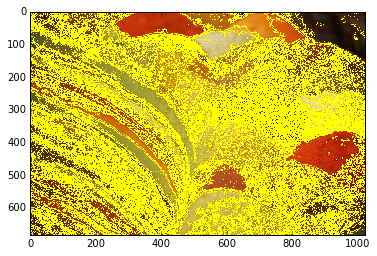

In [23]:
from skimage import segmentation
plt.imshow(segmentation.mark_boundaries(spices, labels))

In [24]:
from skimage import segmentation
segments = segmentation.slic(spices, n_segments=200, compactness=20)

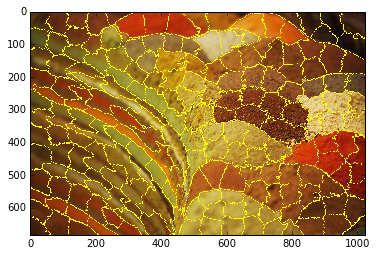

In [25]:
plt.imshow(segmentation.mark_boundaries(spices, segments))

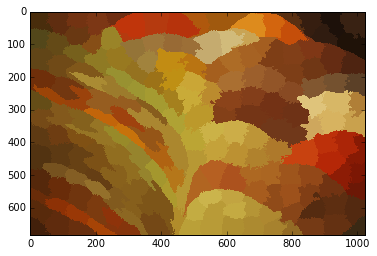

In [26]:
result = color.label2rgb(segments, spices, kind='mean')
plt.imshow(result)

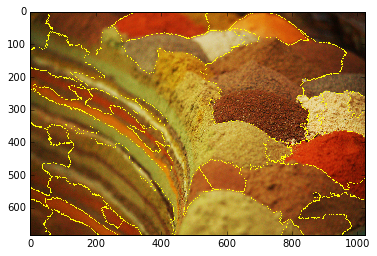

In [27]:
# This could be improved
im_lab = color.rgb2lab(result)
data = np.array([im_lab[..., 1].ravel(),
                 im_lab[..., 2].ravel()])

kmeans = KMeans(n_clusters=5, random_state=0).fit(data.T)
labels = kmeans.labels_.reshape(spices.shape[:-1])
color_mean = color.label2rgb(labels, spices, kind='mean')
plt.imshow(segmentation.mark_boundaries(spices, labels))

## Increasing the number of low-level features: trained segmentation using Gabor filters and random forests

In [32]:
from sklearn.ensemble import RandomForestClassifier
from skimage import filters
from skimage import img_as_float

def _compute_features(im):
    gabor_frequencies = np.logspace(-3, 2, num=6, base=2)
    thetas = [0, np.pi/2]
    nb_fq = len(gabor_frequencies) * len(thetas)
    im = np.atleast_3d(im)
    im_gabor = np.empty((im.shape[-1], nb_fq) + im.shape[:2])
    for ch in range(im.shape[-1]):
        img = img_as_float(im[..., ch])
        for i_fq, fq in enumerate(gabor_frequencies):
            for i_th, theta in enumerate(thetas):
                tmp = filters.gabor(img, fq, theta=theta)
                im_gabor[ch, len(thetas) * i_fq + i_th] = \
                                    np.abs(tmp[0] + 1j * tmp[1])
    return im_gabor


def trainable_segmentation(im, mask):
    """
    Parameters
    ----------
    
    im : ndarray
        2-D image (grayscale or RGB) to be segmented
        
    mask : ndarray of ints
        Array of labels. Non-zero labels are known regions that are used
        to train the classification algorithm.
    """
    # Define features
    im_gabor = _compute_features(im)     
    nb_ch, nb_fq, sh_1, sh2 = im_gabor.shape
    training_data = im_gabor[:, :, mask>0].reshape((nb_ch * nb_fq,
                                                    (mask>0).sum())).T
    training_labels = mask[mask>0].ravel()
    data = im_gabor[:, :, mask == 0].reshape((nb_ch * nb_fq,
                                              (mask == 0).sum())).T
    # classification
    clf = RandomForestClassifier()
    clf.fit(training_data, training_labels)
    labels = clf.predict(data)
    result = np.copy(mask)
    result[mask == 0] = labels
    return result

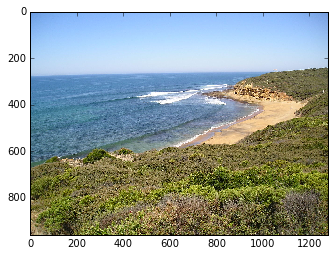

In [33]:
# Image from https://fr.wikipedia.org/wiki/Fichier:Bells-Beach-View.jpg
beach = io.imread('../images/Bells-Beach.jpg')
plt.imshow(beach)

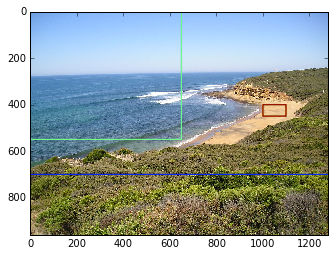

In [34]:
mask = np.zeros(beach.shape[:-1], dtype=np.uint8)
mask[700:] = 1
mask[:550, :650] = 2
mask[400:450, 1000:1100] = 3
plt.imshow(beach)
plt.contour(mask)

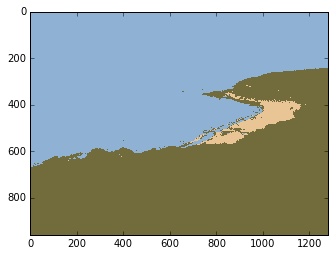

In [35]:
result = trainable_segmentation(beach, mask)
plt.imshow(color.label2rgb(result, beach, kind='mean'))

## Using mid-level features 

[Panorama stitching](adv3_panorama-stitching.ipynb)